In [1]:
import pandas as pd

train_df = pd.read_csv("./data/rainfall_train.csv")
test_df = pd.read_csv("./data/rainfall_test.csv")

train_df = train_df.drop(columns=['Unnamed: 0', 'rainfall_train.fc_year', 'rainfall_train.fc_month',
       'rainfall_train.fc_day', 'rainfall_train.fc_hour'])
test_df = test_df.drop(columns=['Unnamed: 0', 'rainfall_test.fc_year', 'rainfall_test.fc_month',
       'rainfall_test.fc_day', 'rainfall_test.fc_hour'])

train_df = train_df[train_df["rainfall_train.class_interval"] != -999]

In [ ]:
# 각 계급 별 확률로 변경
# v00 = 100 - v01, v01 = v01 - v02 .. v08 = v09 - v08
for i in range(9):
    col = "rainfall_train.v0{}"
    train_df[col.format(i)]  = train_df[col.format(i)] - train_df[col.format(i+1)] if i != 0 else 100 - train_df[col.format(i+1)]

In [33]:
train_df

,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval,rainfall_train.v00
0,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0,100
1,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0,100
2,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0,100
3,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0,100
4,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457247,STN020,228,C,10,10,9,2,5,0,2,0,0,0,0,0,0.5,3,91
1457248,STN020,231,C,10,10,12,4,4,2,2,1,0,0,0,0,0.0,0,87
1457249,STN020,234,C,10,10,15,4,4,2,2,1,0,0,0,0,1.9,4,87
1457250,STN020,237,C,10,10,18,2,2,2,0,2,0,0,0,0,1.9,4,92


In [44]:
nineth = pd.Series()
nineth["all"] = train_df[train_df["rainfall_train.class_interval"] == 9]["rainfall_train.vv"].mean()
nineth["A"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "A")]["rainfall_train.vv"].mean()
nineth["B"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "B")]["rainfall_train.vv"].mean()
nineth["C"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "C")]["rainfall_train.vv"].mean()


In [45]:
nineth

all    47.411380
A      48.352625
B      45.116066
C      47.730769
dtype: float64

**각각의 확률분포에 따라서 강수량 수치 계산: 각 계급별 중간 값 * 확률변수**
- 'rainfall_train.v01' : 0.1 -0.2  (mm)
- 'rainfall_train.v02' : 0.2 -0.5  (mm)
- 'rainfall_train.v03' : 0.5 -1.0  (mm)
- 'rainfall_train.v04' : 1.0 -2.0  (mm)
- 'rainfall_train.v05' : 2.0 -5.0  (mm)
- 'rainfall_train.v06' : 5.0 -10.0 (mm)
- 'rainfall_train.v07' : 10.0-20.0 (mm)
- 'rainfall_train.v08' : 20.0-30.0 (mm)
- 'rainfall_train.v09' : 47      (mm)

각각의 계급별 중간 값과 확률 변수를 곱한 값으로 강수량 기댓값을 산출(v_median)

In [47]:
median_list= [0,0.15,0.35,0.75,1.5,3.5,7.5,15,25,47]
train_df["v_median"] = train_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x:sum([ median_list[idx]* (e/100) for idx,e in enumerate(x)]), axis=1)

In [48]:
train_df["v_median"]

0          0.0000
1          0.0000
2          0.0000
3          0.0000
4          0.0000
            ...  
1457247    0.0505
1457248    0.1000
1457249    0.1000
1457250    0.0950
1457251    0.0950
Name: v_median, Length: 1448762, dtype: float64

In [105]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# max(axis =1)
# columns
# plt.scatter(f1_score(train_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x: x.argmax(),axis=1),train_df["rainfall_train.class_interval"] , average=None))
# 각 클래스마다 F1 Score 점수
# COLUMN, dH 각 클래스
total_array = None
for dh in train_df["rainfall_train.dh"].unique():
    tmp_df = train_df[train_df["rainfall_train.dh"] == dh]
    row = np.concatenate((np.array([dh]),f1_score(tmp_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x: x.argmax(),axis=1), tmp_df["rainfall_train.class_interval"],average=None)),axis=0).reshape(1,11)
    if total_array is None:
        total_array = row.reshape(1,11)
    else:
        total_array = np.concatenate((total_array,row),axis=0)
        
f1_df = pd.DataFrame(data=total_array,columns=["DH"] + ["V{}".format(i) for i in range(10)])


Text(0, 0.5, 'f1_score')

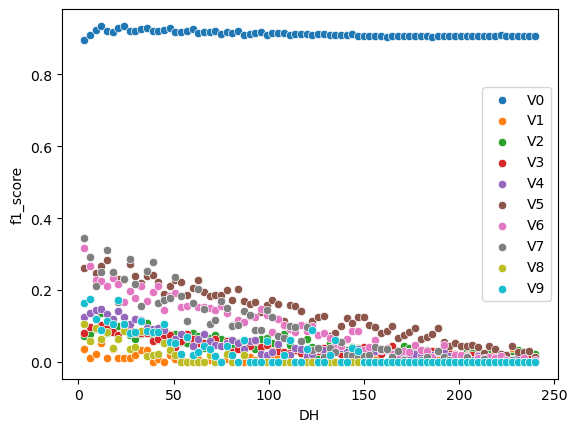

In [ ]:
for i in range(10):
    sns.scatterplot(x= f1_df["DH"],y=f1_df["V{}".format(i)],label="V{}".format(i))
plt.ylabel("f1_score")

Text(0, 0.5, 'f1_score')

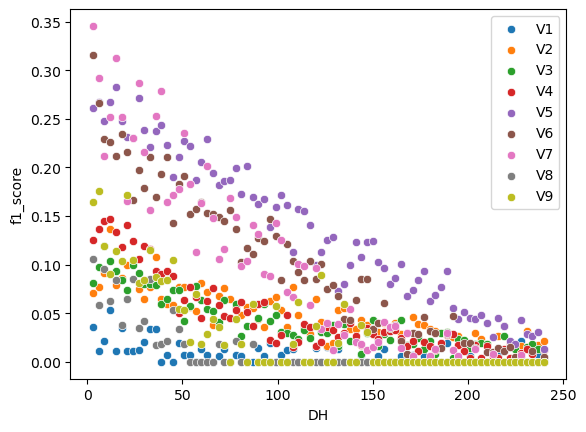

In [108]:
for i in range(1,10):
    sns.scatterplot(x= f1_df["DH"],y=f1_df["V{}".format(i)],label="V{}".format(i))
plt.ylabel("f1_score")